In [289]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

In [290]:
file_path = "data exploration/explored_data.csv"  
data = pd.read_csv(file_path)

print(data.head())

        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review  Rating  \
0  The ambience was good, food was quite good . h...     5.0   
1  Ambience is too good for a pleasant evening. S...     5.0   
2  A must try.. great food great ambience. Thnx f...     5.0   
3  Soumen das and Arun was a great guy. Only beca...     5.0   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0   

                  Time  Pictures  Review_Count  Follower_Count  Review_Length  
0  2019-05-25 15:54:00         0           1.0             2.0            222  
1  2019-05-25 14:20:00         0           3.0             2.0            144  
2  2019-05-24 22:54:00         0           2.0             3.0            189  
3  2019-05-24 22:11:00        

<Axes: xlabel='Average_Restaurant_Rating', ylabel='Review_Count'>

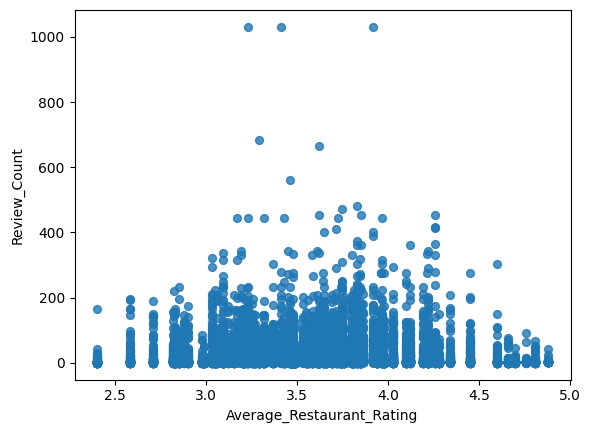

In [291]:
# # cluster according to reviews 
# cluster_features = data[['Rating', 'Review_Count', 'Follower_Count', 'Review_Length']]

average_restaurant_rating = data.groupby('Restaurant')['Rating'].mean().reset_index()
average_restaurant_rating.rename(columns={'Rating': 'Average_Restaurant_Rating'}, inplace=True)
data = data.merge(average_restaurant_rating, on='Restaurant', how='left')
cluster_features = data[['Average_Restaurant_Rating', 'Review_Count', 'Follower_Count', 'Review_Length']]

# Scatter plot visualization of two key features
cluster_features.plot(kind='scatter', x='Average_Restaurant_Rating', y='Review_Count', s=32, alpha=0.8)

In [292]:
# Standardize numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_features)

scaled_cluster_features = pd.DataFrame(scaled_data, columns=['Average_Restaurant_Rating', 'Review_Count', 'Follower_Count', 'Review_Length'])

In [293]:
df_matrix = scaled_cluster_features.to_numpy()

# Determine optimal number of clusters using the Elbow method
cost = []
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, random_state=0, n_init=10)
    kmeans.fit(df_matrix)
    cost.append(kmeans.inertia_)
    print(f'Cluster initiation: {cluster}')
  
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


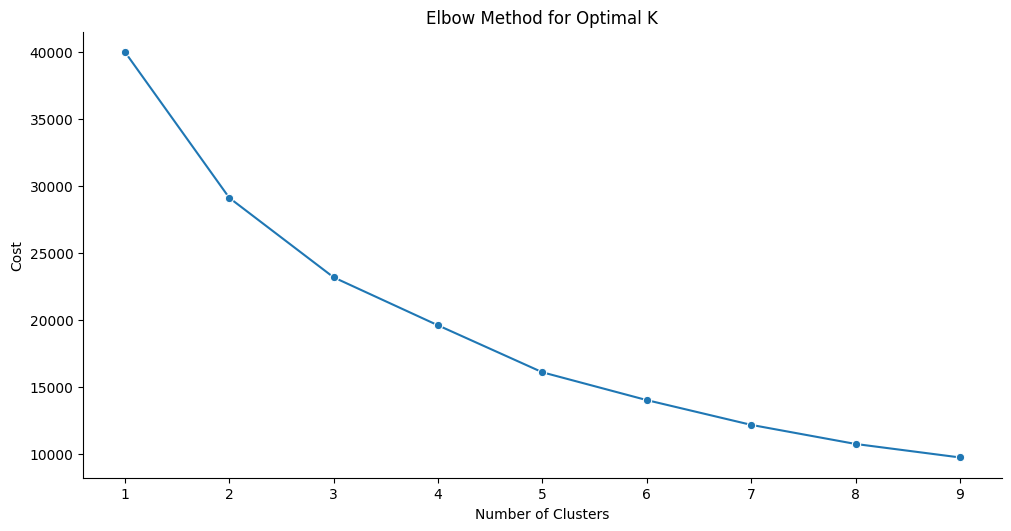

In [294]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
sns.lineplot(x='Cluster', y='Cost', data=df_cost, marker='o')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K')
plt.show()

In [295]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(df_matrix)

cluster_features = cluster_features.copy()
cluster_features['Cluster'] = clusters

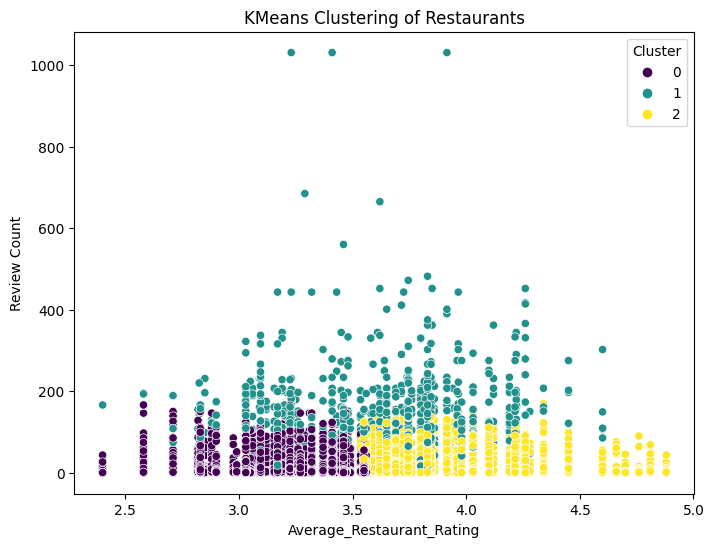

In [296]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Average_Restaurant_Rating', y='Review_Count', hue=cluster_features['Cluster'], palette='viridis', data=cluster_features)
plt.xlabel('Average_Restaurant_Rating')
plt.ylabel('Review Count')
plt.title('KMeans Clustering of Restaurants')
plt.legend(title='Cluster')
plt.show()

In [297]:
print(cluster_features.head())

   Average_Restaurant_Rating  Review_Count  Follower_Count  Review_Length  \
0                       4.28           1.0             2.0            222   
1                       4.28           3.0             2.0            144   
2                       4.28           2.0             3.0            189   
3                       4.28           1.0             1.0            148   
4                       4.28           3.0             2.0            160   

   Cluster  
0        2  
1        2  
2        2  
3        2  
4        2  


In [298]:
user_item_interactions = data.groupby(['Reviewer', 'Restaurant']).size().reset_index(name='frequency')

user_item_interactions = user_item_interactions.merge(
    data[['Reviewer', 'Restaurant', 'Rating', 'Review_Length']], 
    on=['Reviewer', 'Restaurant'], 
    how='left'
)                                          
                                                                                     
item_encoder = LabelEncoder() # restuarant
user_encoder = LabelEncoder() # reviewer

user_item_interactions['user_idx'] = user_encoder.fit_transform(user_item_interactions['Reviewer'])
user_item_interactions['item_idx'] = item_encoder.fit_transform(user_item_interactions['Restaurant'])
user_item_interactions['weight'] = user_item_interactions['Rating'] * user_item_interactions['Review_Length']

rows = user_item_interactions['item_idx']  
cols = user_item_interactions['user_idx']  
weights = user_item_interactions['weight']
sparse_item_matrix = csr_matrix((weights, (rows, cols)))

item_similarity_matrix = cosine_similarity(sparse_item_matrix, dense_output=False)
print(item_similarity_matrix.shape)

(100, 100)


In [299]:
def get_item_based_recommendations(item_similarity_matrix, co_occurrence_matrix, restaurant_id, k=10, sim_threshold=0.0, co_thresh=1):
    """
    Recommends restaurants similar to a given restaurant based on item-based CF.
    
    - item_similarity_matrix: Cosine similarity between restaurants
    - co_occurrence_matrix: Number of shared users between restaurant pairs
    - restaurant_id: Target restaurant ID for recommendations
    - k: Number of recommendations
    - sim_threshold: Minimum similarity score
    - co_thresh: Minimum number of users who reviewed both restaurants
    """
    item_idx = item_encoder.transform([restaurant_id])[0]

    # cosine similarity
    similarity_scores = item_similarity_matrix[item_idx].toarray().flatten()

    # apply similarity and co-occurrence 
    co_occurrences = co_occurrence_matrix[item_idx].toarray().flatten()
    valid_items = np.where((similarity_scores >= sim_threshold) & (co_occurrences >= co_thresh))[0]

    # exlude input itself
    valid_items = valid_items[valid_items != item_idx]  

    # top k
    top_k_items = valid_items[np.argsort(similarity_scores[valid_items])][::-1][:k]

    recommended_restaurant_ids = item_encoder.inverse_transform(top_k_items)
    recommended_similarity_scores = similarity_scores[top_k_items]
    recommended_co_occurrences = co_occurrences[top_k_items]
    recommendations_df = pd.DataFrame({
        'Restaurant': recommended_restaurant_ids,
        'Similarity Score': recommended_similarity_scores,
        'Co-Occurrence Count': recommended_co_occurrences
    })

    return recommendations_df


In [300]:
restaurants_to_recommend = get_item_based_recommendations(item_similarity_matrix, co_occurrence_matrix, 'Beyond Flavours', k=5)
print(restaurants_to_recommend)

                                Restaurant  Similarity Score  \
0                                 Tempteys          0.213688   
1                     Prism Club & Kitchen          0.212314   
2  Komatose - Holiday Inn Express & Suites          0.158236   
3                            Momos Delight          0.051586   
4                           The Indi Grill          0.051166   

   Co-Occurrence Count  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  


In [ ]:
def evaluate_recommendation_system(recommended_items, actual_items, k=10):
    """
    Evaluate the recommendation system using precision, recall, and F1 score.
    
    - recommended_items: List of recommended restaurant IDs for each user.
    - actual_items: List of actual restaurant IDs the user interacted with.
    - k: Number of top recommendations to consider.
    """
    precision_list = []
    recall_list = []
    f1_list = []
    
    # Loop through each user's recommendations and actual items
    for rec, actual in zip(recommended_items, actual_items):
        # Get top-k recommendations and compare with actual items
        top_k_recommendations = rec[:k]
        relevant_recommendations = set(top_k_recommendations).intersection(set(actual))
        
        # Calculate precision, recall, and F1 score
        precision = len(relevant_recommendations) / k
        recall = len(relevant_recommendations) / len(actual)
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    # Calculate average precision, recall, and F1 score
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    
    return avg_precision, avg_recall, avg_f1

# Example Usage
recommended_items = [['Restaurant A', 'Restaurant B', 'Restaurant C'], ['Restaurant D', 'Restaurant E', 'Restaurant F']]  # Example recommendations
actual_items = [['Restaurant A', 'Restaurant D'], ['Restaurant C', 'Restaurant F']]  # Example actual interactions

precision, recall, f1 = evaluate_recommendation_system(recommended_items, actual_items, k=3)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
